In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from osgeo import gdal_array
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from torch import Tensor, einsum
from torch import nn
from torch.nn import functional as F
from scipy.ndimage import distance_transform_edt as distance
from scipy.spatial.distance import directed_hausdorff
from typing import Any, Callable, Iterable, List, Set, Tuple, TypeVar, Union
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import matplotlib
import torch.nn.functional as F


In [2]:
!pip install segmentation-models-pytorch==0.1.0
!pip install keras-unet
!pip install pytorch-lighting

     |████████████████████████████████| 42 kB 334 kB/s eta 0:00:011
     |████████████████████████████████| 58 kB 3.4 MB/s  eta 0:00:01
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=cba9a68dea897104a4b2ff4d69b2f0642fa9eb6a49f68434de6c82f528449d68
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=520637003d5fbc8860f234121f4032ca7406c191c198984e7dbf0f7412954277
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built pretrainedmodels efficientnet-pytorch
ERROR: Could not find a version that satisfies the requirement pytorch-lighting (from versions: none)
ERROR: No matching distribution found for pytorch-lighting


In [19]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl

In [20]:
size = 128
bs = 16 #batchsize
classes = [ 1,  2,   4,  5,  6,  7,  8,  9, 10, 15]
num_class = len(classes)
EPOCH = 300
reduce = 8

In [21]:
def slice (arr, size, inputsize,stride):
    result = []
    if stride is None:
        stride = size
    for i in range(0, (inputsize-size)+1, stride):
        for j in range(0, (inputsize-size)+1, stride):
        
            if arr.ndim == 3:
                s = arr[:,i:(i+size),j:(j+size), ]
            else:
                s = arr[i:(i+size),j:(j+size), ]
            result.append(s)
            #print(i,"",j)
    result = np.array(result)
    return result

def batchslice (arr, size, inputsize, stride, num_img):
    result = []
    for i in range(0, num_img):
        s= slice(arr[i,], size, inputsize, stride )
        result.append(s )
    result = np.array(result)
    result = result.reshape(result.shape[0]*result.shape[1], result.shape[2], result.shape[3], -1)
    return result

def class2dim (mask, CLASSES):
    
        masks = [(mask == v) for v in CLASSES ]
        mask = np.stack(masks, axis=-1).astype('float')    
        return mask

In [22]:
#stack all files into 1 variable
def load_raster(path,data,tile1,tile2,reduce):
   tiles_in=[tile1,tile2]
   files = []
   for tile in tiles_in:
       for file in glob.glob(path+data+'*{}.tif'.format(tile)):
           file1 = gdal_array.LoadFile(file)
           #only use 50% of the points to reduce memory
           if np.ndim(file1)==3:
               file1=file1[:,::reduce,::reduce]
           else:
               file1=file1[::reduce,::reduce]
           files.append(file1)
   stacked = np.array(files)
   return stacked

def load_data(path,data1,data2,tile1,tile2, reduce):
    part1 = load_raster(path,data1,tile1,tile2, reduce )
    part2 = load_raster(path,data2,tile1,tile2,reduce )
    
    if np.ndim(part1)< np.ndim(part2):#check if dimmensions are equal
       part1 = np.expand_dims(part1,axis=1)
    elif np.ndim(part1)> np.ndim(part2):
       part2 = np.expand_dims(part2,axis=1)
    print(part1.shape,part2.shape)
    total = np.concatenate((part1,part2),axis=1)
    return total


In [7]:
x_test0= load_data("../input/guided-research/Test/","DEM","Wadden","14_6","14_8",reduce)
y_test0=load_raster("../input/guided-research/Test/","class","14_6","14_8",reduce )

(2, 1, 2000, 2000) (2, 3, 2000, 2000)


In [8]:
print(x_test0.shape,y_test0.shape)

(2, 4, 2000, 2000) (2, 2000, 2000)


In [9]:
def process(x_test,y_test , size, bslice=True, cl2dim=True, Inf2zero=True):
    if bslice :
        x_test  = batchslice(x_test, size,x_test[0].shape[1],size, x_test.shape[0])
        y_test = batchslice(y_test,size,y_test[0].shape[1],size,y_test.shape[0]).squeeze()
        print(f"batch slice to {size}")
       
    if  cl2dim :    
        y_test = class2dim(y_test, classes)

        y_test=  np.moveaxis(y_test, -1, 1)
        print("classes are converted to channels")
        
    if Inf2zero : 
        x_test[x_test > 1e308] = 0 
        #np.nan
        y_test[y_test >1e308] = 0
        print("inf are converted to 0")
    return(x_test, y_test)

def myloader(testX, testY):

    test = TensorDataset(torch.Tensor(x_test[:,1:4,:,:]), torch.Tensor(y_test )) # create your datset
    test  = DataLoader(test, batch_size=bs) # create your dataloader
    
    return test

In [10]:
x_test, y_test = process(x_test0, y_test0, size =size, bslice=False, cl2dim=True, Inf2zero=True)

classes are converted to channels
inf are converted to 0


(2, 4, 2000, 2000) (2, 10, 2000, 2000)


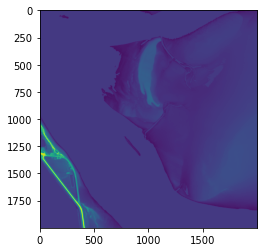

In [11]:
print(x_test.shape, y_test.shape)
plt.imshow(x_test[0,0,])

In [12]:
x_test, y_test = process(x_test0, y_test0, size =size, bslice=True, cl2dim=True, Inf2zero=True)

batch slice to 128
classes are converted to channels
inf are converted to 0


In [13]:
test_loader = myloader(x_test, y_test)

In [14]:
GAMMA = 2
ALPHA = 0.8 # emphasize FP
BETA = 0.2 # more emphasize on FN

# combo loss
cl_ALPHA = 0.5 # < 0.5 penalises FP more, > 0.5 penalises FN more
cl_BETA = 0.5
CE_RATIO = 0.5 #weighted contribution of modified CE loss compared to Dice loss
e=1e-07

In [15]:
def show(img):
    npimg = img.numpy()
    plt.imshow(npimg[1,])
    plt.show()

In [23]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE


     
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, **kwargs):
        super(IoULoss, self).__init__(**kwargs)

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        #print(inputs.shape)
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        #inputs = (inputs>0.5).float()
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()  
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth) 
                
        return 1 - IoU
    
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky
 

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

class myLoss(torch.nn.Module):

    def __init__(self, pos_weight=1):
      super().__init__()
      self.pos_weight = pos_weight

    def forward(self, input, target):
      epsilon = 10 ** -44
      input = input.sigmoid().clamp(epsilon, 1 - epsilon)

      my_bce_loss = -1 * (self.pos_weight * target * torch.log(input)
                          + (1 - target) * torch.log(1 - input))
      add_loss = (target - 0.5) ** 2 * 4
      mean_loss = (my_bce_loss * add_loss).mean()
      return mean_loss
    
 

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
class CNNmodel(pl.LightningModule):
    def __init__(self):
        super(CNNmodel,self).__init__()
        self.batch_size=bs
        self.learning_rate = 2e-4
        self.net = smp.Unet(classes=num_class, in_channels=3, activation = 'softmax')
        self.label_type = torch.float32 if num_class  == 1 else torch.long
    
    def forward(self,x):
        return self.net(x)
    
    def training_step(self,train_batch,batch_nb):
        x,y = train_batch
        y = y.float()
        y_hat = self(x)
        loss1=IoULoss()
        loss = loss1(y_hat, y)
        return{'loss':loss}
    
    def validation_step(self,val_batch,batch_nb):
        x,y = val_batch
        y = y.long()
        y_hat = self(x)
        loss1=IoULoss()
        val_loss = loss1(y_hat, y)
        return val_loss
    def test_step(self,test_batch,batch_nb):
        x,y = test_batch
        y = y.long()
        y_hat = self(x)
        loss=IoULoss()
        loss = loss(y_hat, y)
        self.log('test_loss',loss)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 40], gamma=0.3)
        return [optimizer],[scheduler]
    
    def train_dataloader(self):
        return train_loader
    
    def valid_dataloader(self):
        return valid_loader
    def test_dataloader(self):
        return test_loader

In [39]:
new_model = CNNmodel.load_from_checkpoint(checkpoint_path="../input/gr-wadden/lightning_logs/version_0/checkpoints/epoch=297.ckpt",
                                         hparams_file="../input/gr-wadden/lightning_logs/version_0/hparams.yaml",
                                         maplocation="cpu")
#new_model =new_model.cuda()
trainer=pl.Trainer()

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


In [40]:
result = trainer.test(new_model,test_dataloaders=test_loader)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.3230)}
--------------------------------------------------------------------------------



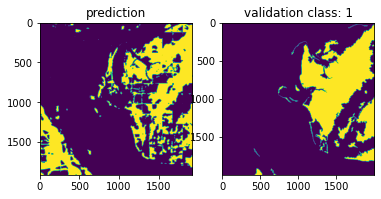

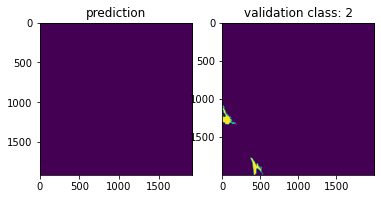

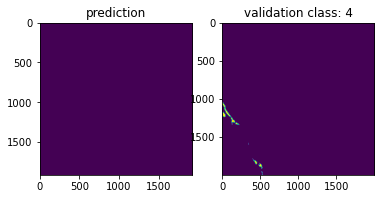

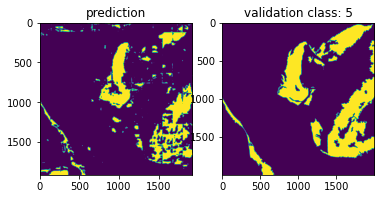

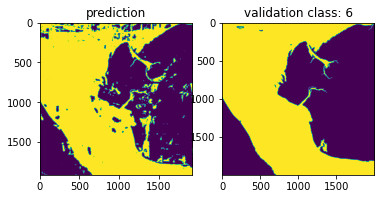

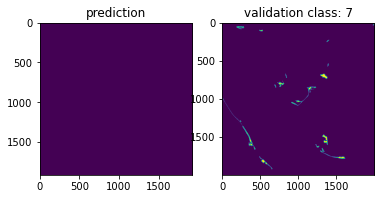

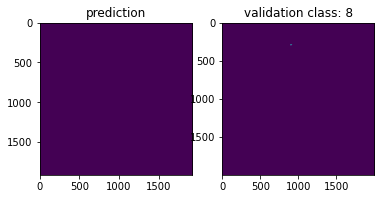

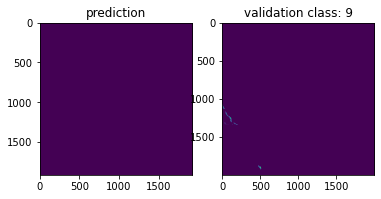

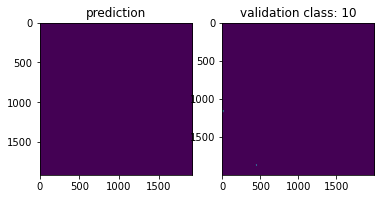

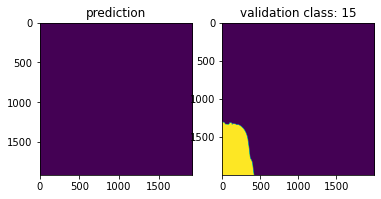

In [44]:
numimag = np.sqrt(x_test.shape[0]/2).astype(int)
num = (numimag*numimag+1).astype(int)
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,8)) 
#for ii,axi in enumerate(ax.flat):
classes = [1,2,4,5,6,7,8,9,10,15]
for wc in range (10) :
    
        #for the first tile only
    result = np.zeros((1,size, size))
    with torch.no_grad():
        for data in test_loader:
            images, labels = data 
            output1 = new_model(images)
            output1 = (output1   > .5).detach().numpy().astype(int)
            p1 = output1[:,wc,] #np.sum(output1[0,], axis = 0).astype(bool).astype(int)    
            
            result = np.concatenate((result, p1),axis=0)
           # print(result.shape)     
    result = result[1:num,:,:]

    result= np.moveaxis(result, 0, -1)

    big = np.zeros((numimag*size, numimag*size))

    for j in range(numimag):    
        for i in range(numimag):
            big[j*size: (j+1)*size,i*size: (i+1)*size]= result[:,:,i+j*numimag]


    plt.subplot(1,2,1)
    plt.title('prediction')
    plt.imshow(big)
    plt.subplot(1,2,2)
    plt.imshow(y_test0[0,]==classes[wc])
    plt.title(f'validation class: {classes[wc]}')
    plt.show()

In [53]:
label_all = range(10) 
ori_val = classes # random numpy numbers

enum_val = [x for n, x in enumerate(ori_val) if x not in ori_val[:n]]

sort_val = np.sort(enum_val)
dic_label = {}
for ind, v in enumerate(sort_val):
    dic_label[v] = label_all[ind]
print(dic_label) 

y_label = np.zeros((big.shape[0],big.shape[1]))
for i in range(big.shape[0]):
    for j in range(big.shape[1]):
        y_label[i,j] = dic_label[y_test0[0,i,j]]

{1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8, 15: 9}


KeyError: 3

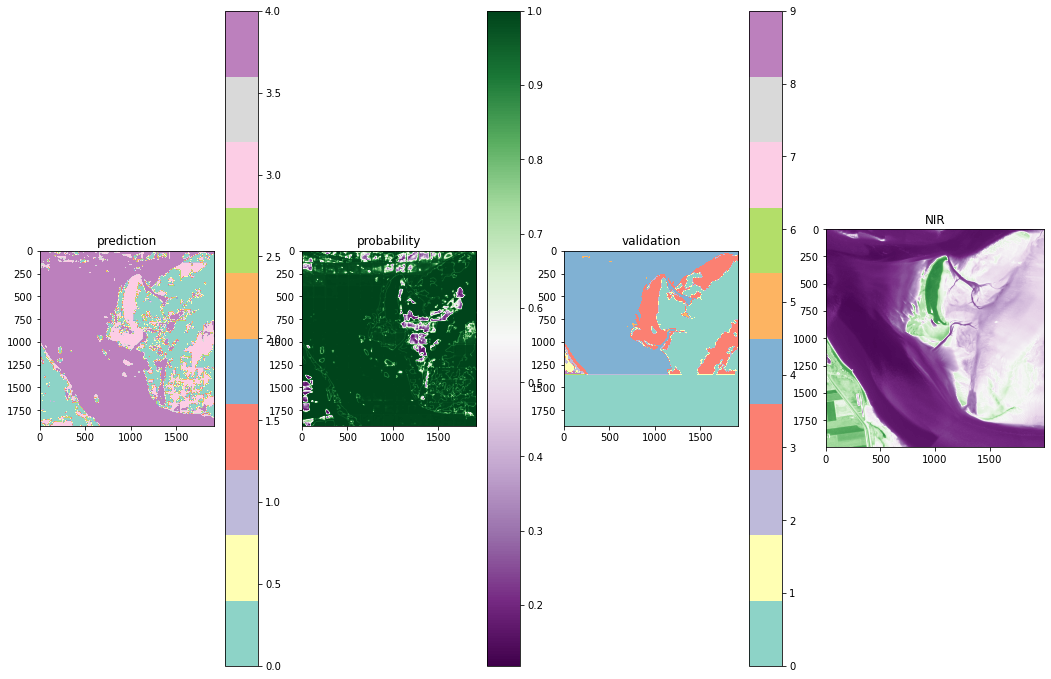

In [49]:
result = np.zeros((1,size, size))
result2 = np.zeros((1,size, size))
with torch.no_grad():
        for data in test_loader:
            images, labels = data 
            output1 = new_model(images)
            p1 = torch.argmax(output1, dim = 1).cpu().numpy()
            result = np.concatenate((result, p1),axis=0)
           
            p2,_ = torch.max(output1,  1)
           
            result2 = np.concatenate((result2, p2.numpy()),axis=0)
            #print(p1.shape, result.shape) 
             
result = result[1:num,:,:]

result= np.moveaxis(result, 0, -1)

result2 = result2[1:num,:,:]

result2= np.moveaxis(result2, 0, -1)
#np.place(result, result>-1, classes) 
#result[result==0]='nan' 
 
big = np.zeros((numimag*size, numimag*size))
big2 = np.zeros((numimag*size, numimag*size))
 
for j in range(numimag):    
        for i in range(numimag):
            big[j*size: (j+1)*size,i*size: (i+1)*size]= result[:,:,i+j*numimag]
            big2[j*size: (j+1)*size,i*size: (i+1)*size]= result2[:,:,i+j*numimag]
            

#from scipy.stats import rankdata
#val = rankdata(y_val0[0,]).reshape(1000, 1000)

cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Set3").colors[:10])
plt.figure(figsize=(18,18))
plt.subplot(1,4,1)
plt.title('prediction')
plt.imshow(big,cmap=cmap)
plt.colorbar()

plt.subplot(1,4,2)
plt.title('probability')
plt.imshow(big2,cmap="PRGn")
plt.colorbar()


plt.subplot(1,4,3)
plt.imshow(y_label,cmap=cmap)
plt.colorbar()
plt.title(f'validation')
plt.subplot(1,4,4)
plt.imshow(x_test0[0,1,],cmap=plt.get_cmap("PRGn"))
#plt.colorbar()
plt.title(f'NIR')

plt.show()

2nd tile

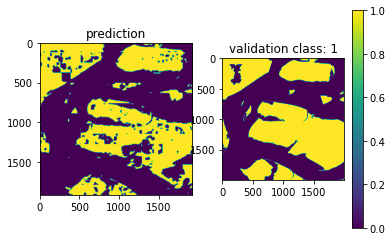

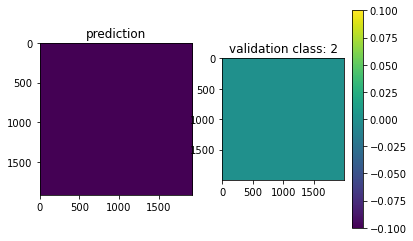

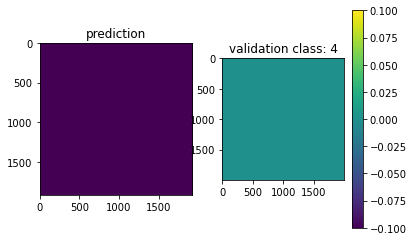

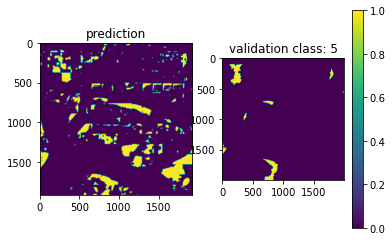

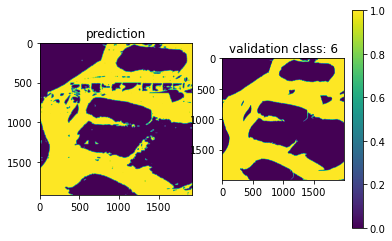

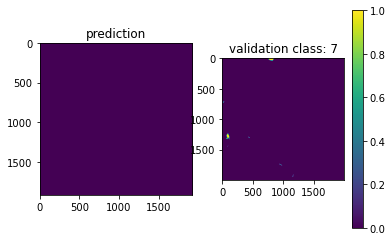

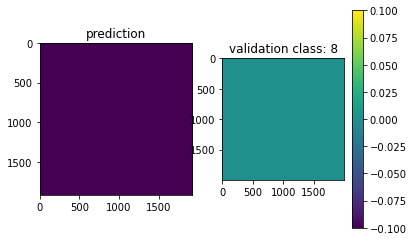

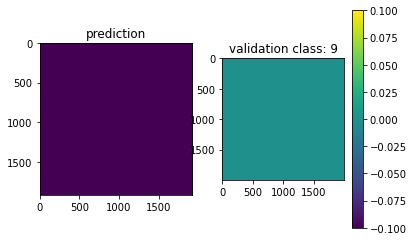

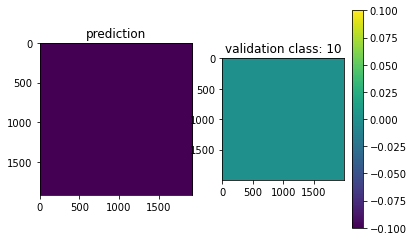

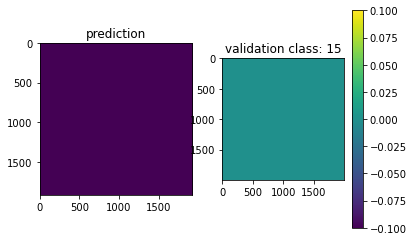

In [59]:
numimag = np.sqrt(x_test.shape[0]/2).astype(int)
num = (numimag*numimag+1).astype(int)
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,8)) 
#for ii,axi in enumerate(ax.flat):
classes = [1,2,4,5,6,7,8,9,10,15]
for wc in range (10) :
    
        #for the first tile only
    result = np.zeros((1,size, size))
    with torch.no_grad():
        for data in test_loader:
            images, labels = data 
            output1 = new_model(images)
            output1 = (output1   > .5).detach().numpy().astype(int)
            p1 = output1[:,wc,] #np.sum(output1[0,], axis = 0).astype(bool).astype(int)    

            result = np.concatenate((result, p1),axis=0)
           # print(result.shape)     
    result = result[num:,:,:]

    result= np.moveaxis(result, 0, -1)

    big = np.zeros((numimag*size, numimag*size))

    for j in range(numimag):    
        for i in range(numimag):
            big[j*size: (j+1)*size,i*size: (i+1)*size]= result[:,:,i+j*numimag]


    plt.subplot(1,2,1)
    plt.title('prediction')
    plt.imshow(big)
    plt.subplot(1,2,2)
    plt.imshow(y_test0[1,]==classes[wc])
    plt.title(f'validation class: {classes[wc]}')
    plt.colorbar()
    plt.show()

In [60]:
label_all = range(10) 
ori_val = classes # random numpy numbers

enum_val = [x for n, x in enumerate(ori_val) if x not in ori_val[:n]]

sort_val = np.sort(enum_val)
dic_label = {}
for ind, v in enumerate(sort_val):
    dic_label[v] = label_all[ind]
print(dic_label) 

y_label = np.zeros((big.shape[0],big.shape[1]))
for i in range(big.shape[0]):
    for j in range(big.shape[1]):
        y_label[i,j] = dic_label[y_test0[1,i,j]]

{1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8, 15: 9}


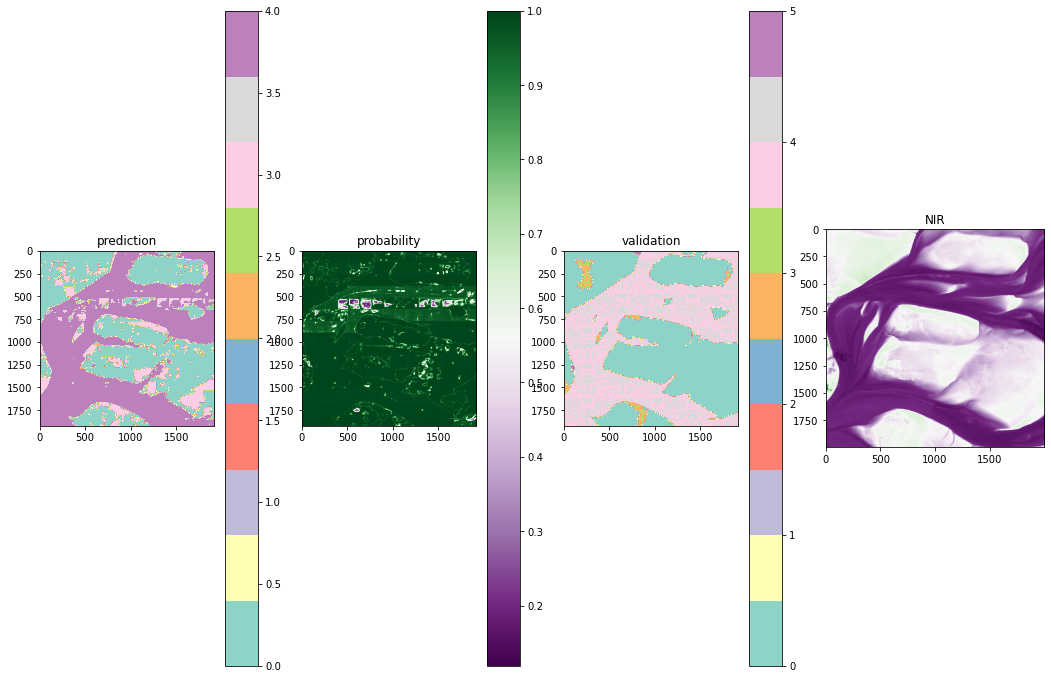

In [75]:
result = np.zeros((1,size, size))
result2 = np.zeros((1,size, size))
with torch.no_grad():
        for data in test_loader:
            images, labels = data 
            output1 = new_model(images)
            p1 = torch.argmax(output1, dim = 1).cpu().numpy()
            result = np.concatenate((result, p1),axis=0)
           
            p2,_ = torch.max(output1,  1)
           
            result2 = np.concatenate((result2, p2.numpy()),axis=0)
            #print(p1.shape, result.shape) 
             
result = result[num:,:,:]

result= np.moveaxis(result, 0, -1)

result2 = result2[num:,:,:]

result2= np.moveaxis(result2, 0, -1)
#np.place(result, result>-1, classes) 
#result[result==0]='nan' 
 
big = np.zeros((numimag*size, numimag*size))
big2 = np.zeros((numimag*size, numimag*size))
 
for j in range(numimag):    
        for i in range(numimag):
            big[j*size: (j+1)*size,i*size: (i+1)*size]= result[:,:,i+j*numimag]
            big2[j*size: (j+1)*size,i*size: (i+1)*size]= result2[:,:,i+j*numimag]
            

#from scipy.stats import rankdata
#val = rankdata(y_val0[0,]).reshape(1000, 1000)

cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Set3").colors[:10])
plt.figure(figsize=(18,18))
plt.subplot(1,4,1)
plt.title('prediction')
plt.imshow(big,cmap=cmap)
plt.colorbar()

plt.subplot(1,4,2)
plt.title('probability')
plt.imshow(big2,cmap="PRGn")
plt.colorbar()


plt.subplot(1,4,3)
plt.imshow(y_label,cmap=cmap)
plt.colorbar()
plt.title(f'validation')
plt.subplot(1,4,4)
plt.imshow(x_test0[1,1,],cmap=plt.get_cmap("PRGn"))
#plt.colorbar()
plt.title(f'NIR')

plt.show()